In [1]:
import os
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
#!rm "/home/adityab2/ZIPS/img12/train/D ≤ (60%R)_44817.PNG"

In [3]:
# Path to the data directory
train_dir = Path("/home/adityab2/ZIPS/img12/train/")
val_dir = Path("/home/adityab2/ZIPS/img12/val")


# Get list of all the images
images = list(train_dir.glob("*.PNG"))
print("Number of train images found: ", len(images))
val_images = list(val_dir.glob("*.PNG"))
print("Number of val images found: ", len(val_images))

Number of train images found:  36530
Number of val images found:  8290


Shape of image:  (45, 27, 3)
Shape of image:  (45, 58, 3)
Shape of image:  (45, 155, 3)
Shape of image:  (45, 97, 3)


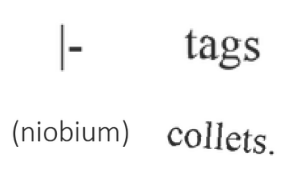

In [4]:
# Let's take a look at some samples first. 
# Always look at your data!
sample_images = val_images[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    img = cv2.imread(str(sample_images[i]))
    print("Shape of image: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

In [5]:
# Store all the characters in a set
characters = set()

# A list to store the length of each captcha
captcha_length = []

# Store image-label info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.name.split("_")[0]
    label = label.split(".PNG")[0]
    # 2. Store the length of label = img_path.name.split("_")[0]this cpatcha
    captcha_length.append(len(label))
    # 3. Store the image-label pair info
    filename = img_path.name
    dataset.append((filename, label))
    
    # 4. Store the characters present
    for ch in label:
        characters.add(ch)

# Sort the characters        
characters = sorted(characters)

# Convert the dataset info into a dataframe
dataset = pd.DataFrame(dataset, columns=["FILENAME", "IDENTITY"], index=None)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)


print("Number of unqiue charcaters in the whole dataset: ", len(characters))
print("Maximum length of any captcha: ", max(Counter(captcha_length).keys()))
print("Characters present: ", characters)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head()
dataset.to_csv("/home/adityab2/ZIPS/img12/trainocr.csv")

Number of unqiue charcaters in the whole dataset:  93
Maximum length of any captcha:  36
Characters present:  [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '\\', ']', '^', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '≤', '≥']
Total number of samples in the dataset:  36530


In [6]:
# Store all the characters in a set
characters = set()

# A list to store the length of each captcha
captcha_length = []

# Store image-label info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in val_images:
    # 1. Get the label associated with each image
    label = img_path.name.split("_")[0]
    label = label.split(".PNG")[0]
    # 2. Store the length of this cpatcha
    captcha_length.append(len(label))
    # 3. Store the image-label pair info
    filename = img_path.name
    dataset.append((filename, label))
    
    # 4. Store the characters present
    for ch in label:
        characters.add(ch)

# Sort the characters        
characters = sorted(characters)

# Convert the dataset info into a dataframe
dataset = pd.DataFrame(dataset, columns=["FILENAME", "IDENTITY"], index=None)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)


print("Number of unqiue charcaters in the whole dataset: ", len(characters))
print("Maximum length of any captcha: ", max(Counter(captcha_length).keys()))
print("Characters present: ", characters)
print("Total number of samples in the dataset: ", len(dataset))
dataset.head()
dataset.to_csv("/home/adityab2/ZIPS/img12/valocr.csv")

Number of unqiue charcaters in the whole dataset:  85
Maximum length of any captcha:  27
Characters present:  [' ', '"', '$', '%', '(', ')', '*', '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '}', '~', '≤', '≥']
Total number of samples in the dataset:  8290


In [7]:
train = pd.read_csv('/home/adityab2/ZIPS/img12/trainocr.csv')
valid = pd.read_csv('/home/adityab2/ZIPS/img12/valocr.csv')

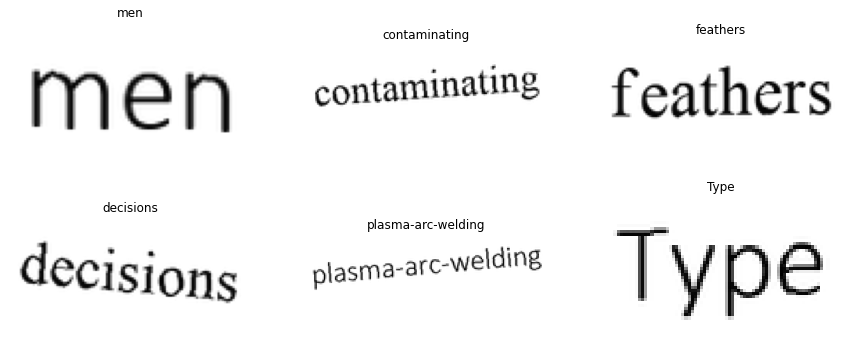

In [8]:
plt.figure(figsize=(15, 20))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/home/adityab2/ZIPS/img12/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [9]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  2
Number of NaNs in validation set :  0


In [10]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

In [11]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [12]:
def preprocess(img):
    (h, w) = img.shape
    #print(img)
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [13]:
train_size = 36460
valid_size= 8270

In [14]:
train_x = []

for i in range(train_size):
    img_dir = '/home/adityab2/ZIPS/img12/train/'+train.loc[i, 'FILENAME']
    #print(img_dir)
    img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    
    img = preprocess(img)
    img = img/255.
    train_x.append(img)

In [15]:
valid_x = []

for i in range(valid_size):
    img_dir = '/home/adityab2/ZIPS/img12/val/'+valid.loc[i, 'FILENAME']
    images = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    images = preprocess(images)
    images = images/255.
    valid_x.append(images)

In [16]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [17]:
#alphabets = u"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ-'+!%(),.0123456789@_¢«°—’”•≤≥= "
alphabets = u"*!#$&<%>\'()+^,?-\\.;:\"=@}`{≤]_~[|≥0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz " 
max_str_len = 36 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [18]:
name = '16=Xx<'
print(name, '\n',label_to_num(name))

16=Xx< 
 [34 39 21 66 92  5]


In [19]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])  

In [20]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

In [21]:
print('True label : ',train.loc[8, 'IDENTITY'] , '\ntrain_y : ',train_y[8],'\ntrain_label_len : ',train_label_len[8], 
      '\ntrain_input_len : ', train_input_len[8])

True label :  B89 
train_y :  [44. 41. 42. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.] 
train_label_len :  [3.] 
train_input_len :  [62.]


In [22]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)

inner = Conv2D(48, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)

inner = MaxPooling2D(pool_size=(2, 2), name='max4')(inner)


inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.2)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.2)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm3')(inner)
inner = Dense(128, activation='relu', kernel_initializer='he_normal', name='dense2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense3')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

2022-07-21 22:57:39.953431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 22:57:40.025335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 22:57:40.025488: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-21 22:57:40.025918: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 conv4 (Conv2D)              (None, 256, 64, 48)       13872     
                                                                 
 batch_normalization_1 (Batc  (None, 256, 64, 48)      192       
 hNormalization)                                             

In [23]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [24]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
ignore_longer_outputs_than_inputs=True

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [25]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
#file_path_best = "/home/adityab2/ZIPS/img12/200-img12-new-ar-{epoch:02d}-{val_loss:.2f}.hdf5"
file_path_best = "/home/adityab2/ZIPS/img12/img12-final 20epochs.hdf5"
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer= 'Adam')

#checkpoint = ModelCheckpoint(filepath=file_path_best, monitor='val_loss', verbose=1, save_freq='epoch',period=20)

checkpoint = ModelCheckpoint(filepath=file_path_best, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

epoch = 20
callbacks_list = [checkpoint]

In [26]:
history = model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output), epochs = epoch, callbacks=callbacks_list)

2022-07-21 22:57:41.682529: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2389442560 exceeds 10% of free system memory.
2022-07-21 22:57:42.093535: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2389442560 exceeds 10% of free system memory.


Epoch 1/120


2022-07-21 22:57:47.637620: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-07-21 22:57:49.483656: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1140/1140 [==============================] - ETA: 0s - loss: 13.3940

2022-07-21 22:58:37.412973: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 541982720 exceeds 10% of free system memory.
2022-07-21 22:58:38.126589: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 541982720 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 1.43730, saving model to /home/adityab2/ZIPS/img12/img12-final 120epochs.hdf5
1140/1140 [==============================] - 61s 47ms/step - loss: 13.3940 - val_loss: 1.4373
Epoch 2/120
1139/1140 [============================>.] - ETA: 0s - loss: 0.3566
Epoch 2: val_loss improved from 1.43730 to 0.20747, saving model to /home/adityab2/ZIPS/img12/img12-final 120epochs.hdf5
1140/1140 [==============================] - 50s 44ms/step - loss: 0.3565 - val_loss: 0.2075
Epoch 3/120
1139/1140 [============================>.] - ETA: 0s - loss: 0.2135
Epoch 3: val_loss did not improve from 0.20747
1140/1140 [==============================] - 50s 44ms/step - loss: 0.2135 - val_loss: 137.2586
Epoch 4/120
1139/1140 [============================>.] - ETA: 0s - loss: 0.1706
Epoch 4: val_loss improved from 0.20747 to 0.12678, saving model to /home/adityab2/ZIPS/img12/img12-final 120epochs.hdf5
1140/1140 [==============================] - 50s 44ms/step - loss: 0.17

KeyboardInterrupt: 

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [28]:
model.load_weights('/home/adityab2/ZIPS/img12/img12-final 120epochs.hdf5')

In [29]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

2022-07-21 23:16:47.240530: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 541982720 exceeds 10% of free system memory.


259/259 [==============================] - 5s 13ms/step


In [30]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 98.77%
Correct words predicted      : 98.60%


1/1 [==============================] - 0s 12ms/step


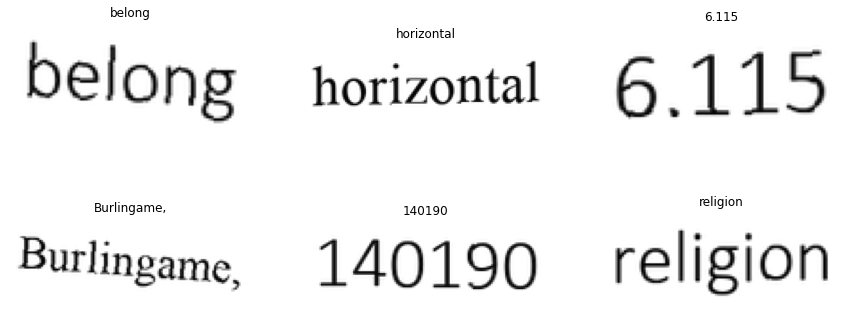

In [31]:
test = pd.read_csv('/home/adityab2/ZIPS/img12/valocr.csv')

plt.figure(figsize=(15, 20))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/home/adityab2/ZIPS/img12/val/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [34]:
pwd

'/home/adityab2/ZIPS/img12'

1/1 [==============================] - 0s 13ms/step


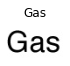

In [40]:
plt.figure(figsize=(1, 1))
for i in range(1):
    ax = plt.subplot(1, 1, i+1)
    img_dir = "/home/adityab2/ZIPS/gas.jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

1/1 [==============================] - 0s 13ms/step


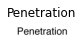

In [39]:
plt.figure(figsize=(1, 1))
for i in range(1):
    ax = plt.subplot(1, 1, i+1)
    img_dir = "/home/adityab2/ZIPS/pen.jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

1/1 [==============================] - 0s 13ms/step


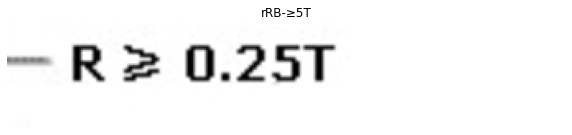

In [38]:
plt.figure(figsize=(10, 10))
for i in range(1):
    ax = plt.subplot(1, 1, i+1)
    img_dir = "/home/adityab2/ZIPS/saved_2b.jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

1/1 [==============================] - 0s 14ms/step


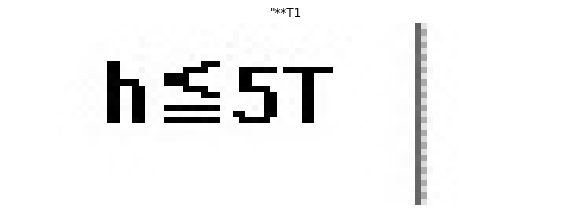

In [48]:
plt.figure(figsize=(10, 10))
for i in range(1):
    ax = plt.subplot(1, 1, i+1)
    img_dir = "/home/adityab2/ZIPS/saved_1.jpg"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

1/1 [==============================] - 0s 13ms/step


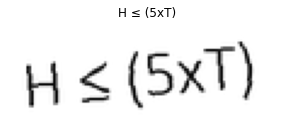

In [36]:
plt.figure(figsize=(5, 5))
for i in range(1):
    ax = plt.subplot(1, 1, i+1)
    img_dir = "/home/adityab2/ZIPS/img12/train/H ≤ (5xT) _44789.PNG"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

1/1 [==============================] - 0s 13ms/step


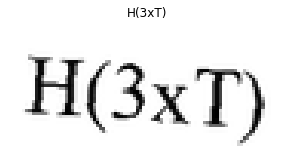

In [42]:
plt.figure(figsize=(5, 5))
for i in range(1):
    ax = plt.subplot(1, 1, i+1)
    img_dir = "/home/adityab2/ZIPS/img12/train/H(3xT)_35708.PNG"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

1/1 [==============================] - 0s 13ms/step


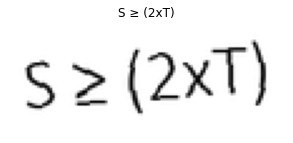

In [43]:
plt.figure(figsize=(5, 5))
for i in range(1):
    ax = plt.subplot(1, 1, i+1)
    img_dir = "/home/adityab2/ZIPS/img12/train/S ≥ (2xT)_44809.PNG"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

1/1 [==============================] - 0s 13ms/step


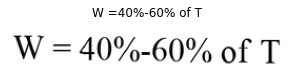

In [44]:
plt.figure(figsize=(5, 5))
for i in range(1):
    ax = plt.subplot(1, 1, i+1)
    img_dir = "/home/adityab2/ZIPS/img12/train/W = 40%-60% of T_44793.PNG"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

1/1 [==============================] - 0s 13ms/step


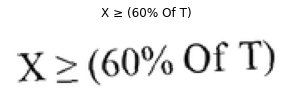

In [45]:
plt.figure(figsize=(5, 5))
for i in range(1):
    ax = plt.subplot(1, 1, i+1)
    img_dir = "/home/adityab2/ZIPS/img12/train/X ≥ (60% Of T)_44803.PNG"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')

1/1 [==============================] - 0s 13ms/step


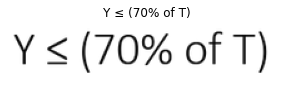

In [46]:
plt.figure(figsize=(5, 5))
for i in range(1):
    ax = plt.subplot(1, 1, i+1)
    img_dir = "/home/adityab2/ZIPS/img12/train/Y ≤ (70% of T) _44791.PNG"
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')